In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import math
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


# Utility Functions

In [2]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.close()
def show_samples(sample_images, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (img_size, img_size))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.show()
    plt.close()

In [3]:
import xml.etree.ElementTree as ET
from PIL import Image


# Hyperparameters
img_size = 64
latent_dim = 100

# Input images
train_X = []

# Build breed dictionary 
breed_dict = {}
for breed in os.listdir('../input/annotation/Annotation/'):
    breed_code = breed.split('-')[0]
    breed_dict[breed_code] = breed

# Crop images function (return list of objects)
def crop_image(path):
    image = Image.open(path)
    filename = path.split('/')[-1]
    anotation_file = '../input/annotation/Annotation/' + breed_dict[filename.split('_')[0]] + '/' + filename[:-4]
    root = ET.parse(anotation_file).getroot()
    bndboxes = []
    for dog_object in root.findall('object'):
        bndbox = dog_object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        xdiff = xmax - xmin
        ydiff = ymax - ymin
        crop_size = min(xdiff,ydiff)
        cropped = image.crop((xmin,ymin,xmin + crop_size, ymin + crop_size))
        cropped = cropped.resize((img_size, img_size), Image.ANTIALIAS)
        train_X.append(np.asarray(cropped))


img_path = '../input/all-dogs/all-dogs/'
img_list = [os.path.join(img_path, f) for f in os.listdir(img_path)]
for path in tqdm(img_list):
    crop_image(path)
train_X = np.asarray(train_X)
# train_X = np.asarray([np.asarray(Image.open(path).resize((img_size, img_size), Image.ANTIALIAS)) for path in img_list])
# Normalize pixels to [-1,1]
train_X = train_X.astype('float32')
train_X = (train_X - 127.5) / 127.5

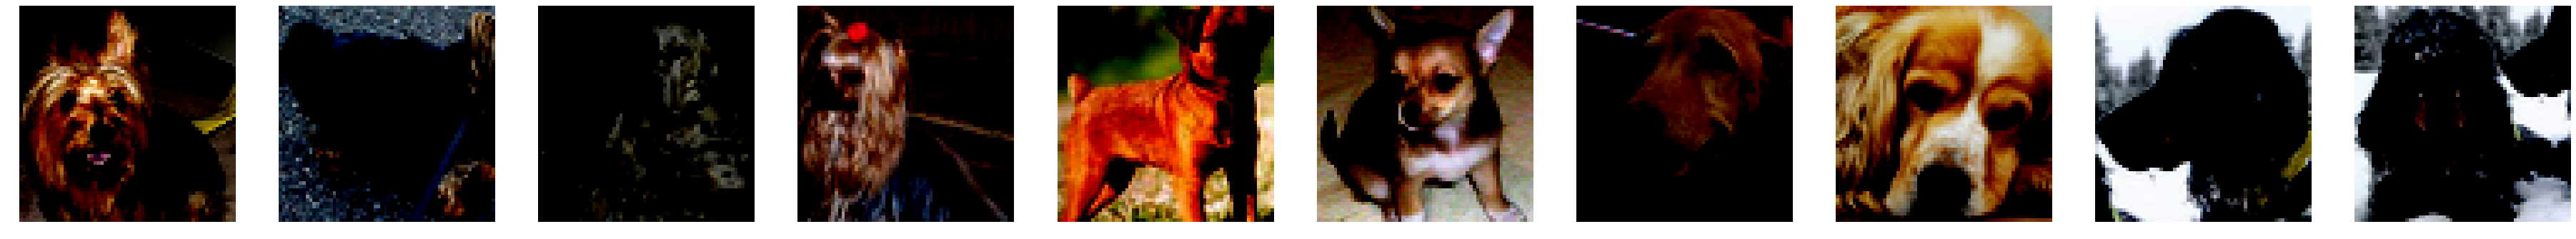

In [4]:
show_samples(train_X[0:10],0)

# Build discriminator

In [5]:
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Activation, Reshape, LeakyReLU, Dropout, Flatten, ReLU, Input
from keras.layers.normalization import BatchNormalization

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(32, (5,5), strides = (2,2),padding = 'same', input_shape = (img_size, img_size, 3)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU())
    
    discriminator.add(Conv2D(64, (5,5),strides = (2,2), padding = 'same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU())
    
    discriminator.add(Conv2D(128, (5,5),strides = (2,2), padding = 'same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU())
    
    discriminator.add(Conv2D(256, (5,5), padding = 'same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU())
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    return discriminator

Using TensorFlow backend.


# Build Generator

In [6]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(4*4*256, input_shape = (latent_dim,)))
    generator.add(Reshape((4,4,256)))
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(256, (5,5), strides = (2,2), padding = 'same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(128, (5,5), strides = (2,2), padding = 'same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(64, (5,5), strides = (2,2),padding = 'same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(32, (5,5), strides = (2,2),padding = 'same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(16, (5,5), padding = 'same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(3, (5,5), padding = 'same'))
    generator.add(Activation('tanh'))
    
    assert generator.output_shape == (None, img_size, img_size, 3)
    return generator

# Define RaGAN model to train

In [7]:
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
dis_lr = 0.0005
gan_lr = 0.0001
batch_size = 16

# Define variables
real_images = Input(shape=(img_size,img_size,3))
gen_input = Input(shape=(latent_dim,))

generator = create_generator()
fake_images = generator(gen_input)

discriminator = create_discriminator()
dis_output_real = discriminator(real_images)
dis_output_fake = discriminator(fake_images)
fake_avg = K.mean(dis_output_fake, axis = 0)
real_avg = K.mean(dis_output_real, axis = 0)

real_fake = dis_output_real - fake_avg
fake_real = dis_output_fake - real_avg

labels = np.ones((batch_size,1))
def discriminator_loss(y_true, y_pred):
    return (K.pow(K.mean(real_fake - 1),2) + K.pow(K.mean(fake_real + 1),2))/2

def gen_loss(y_true, y_pred):
    return (K.pow(K.mean(real_fake + 1),2) + K.pow(K.mean(fake_real - 1),2))/2
# Build a discriminator

dis_optimizer = Adam(lr=dis_lr)
dis_train = Model([gen_input,real_images],[dis_output_real,dis_output_fake])
generator.trainable = False
discriminator.trainable = True
dis_train.compile(dis_optimizer,loss=[discriminator_loss,None])
dis_train.summary()
# Build GAN model
gen_optimizer = Adam(lr=gan_lr)
gen_train = Model([gen_input,real_images],[dis_output_real, dis_output_fake])
generator.trainable = True
discriminator.trainable = False
gen_train.compile(gen_optimizer, loss = [gen_loss, None])
gen_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 3)    3143779     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            1096385     input_1[0][0]                    
                                                                 sequential_1[1][0]               
Total para

# Train model

Epoch 0: 
Discriminator loss: 0.10575751960277557
Generator loss: 4.362863


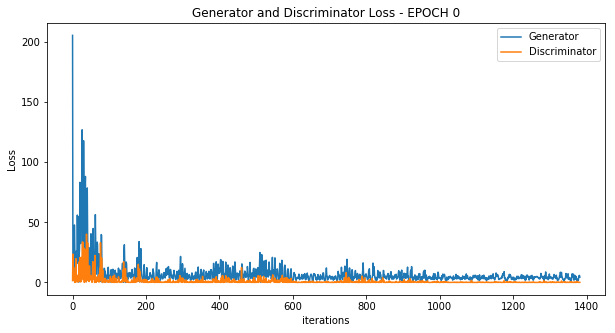

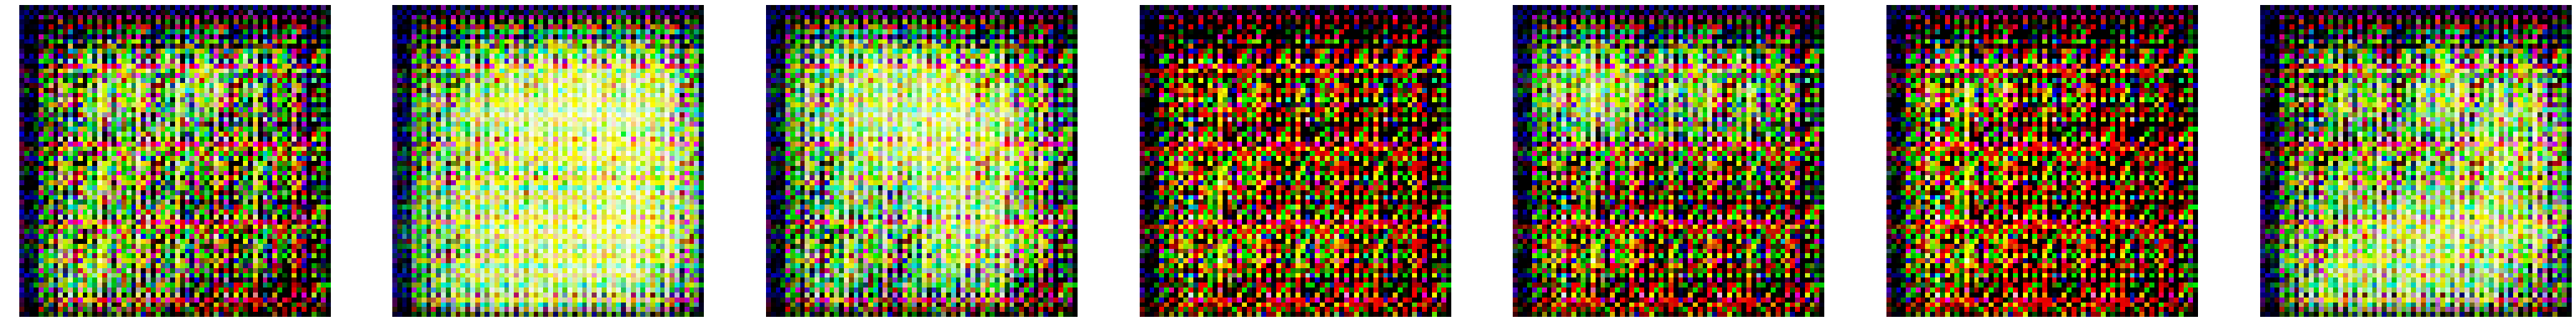

Epoch 50: 
Discriminator loss: 4.1684012103360146e-05
Generator loss: 4.6614733


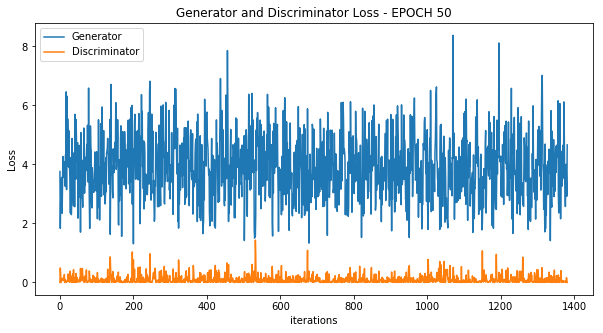

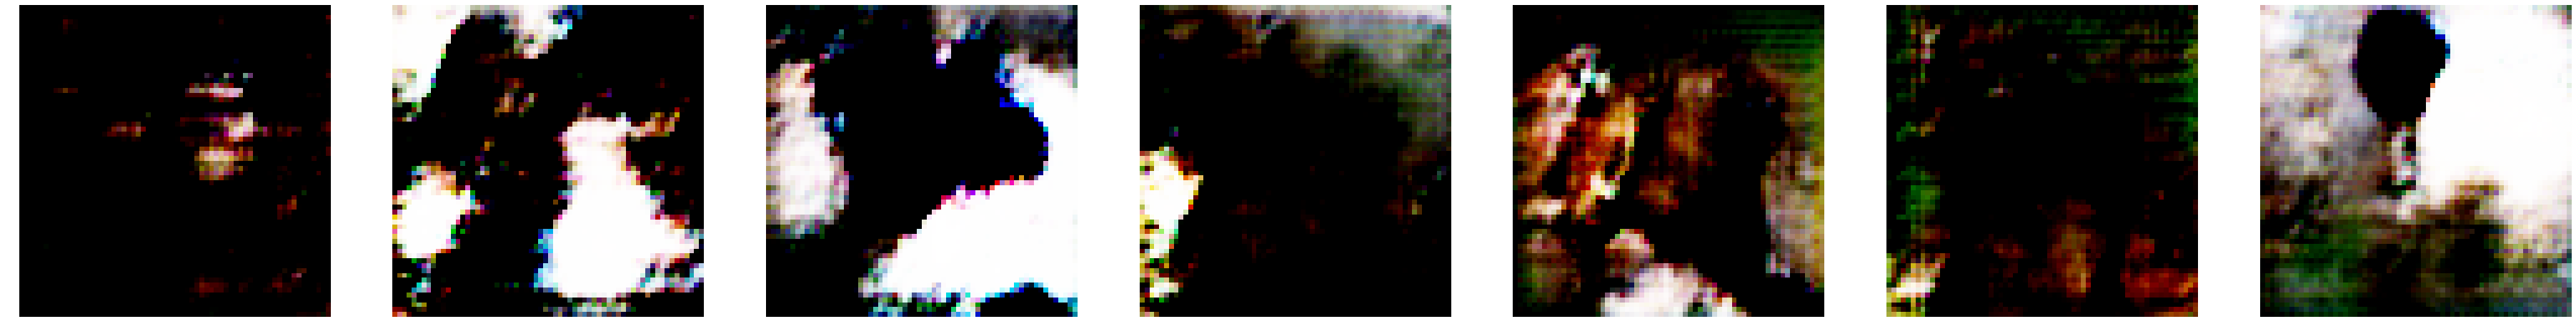

Epoch 100: 
Discriminator loss: 0.0005554803647100925
Generator loss: 3.9592137


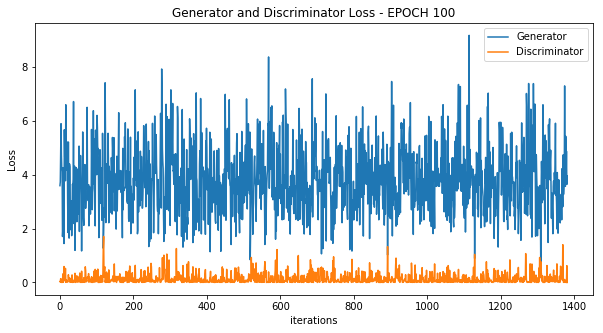

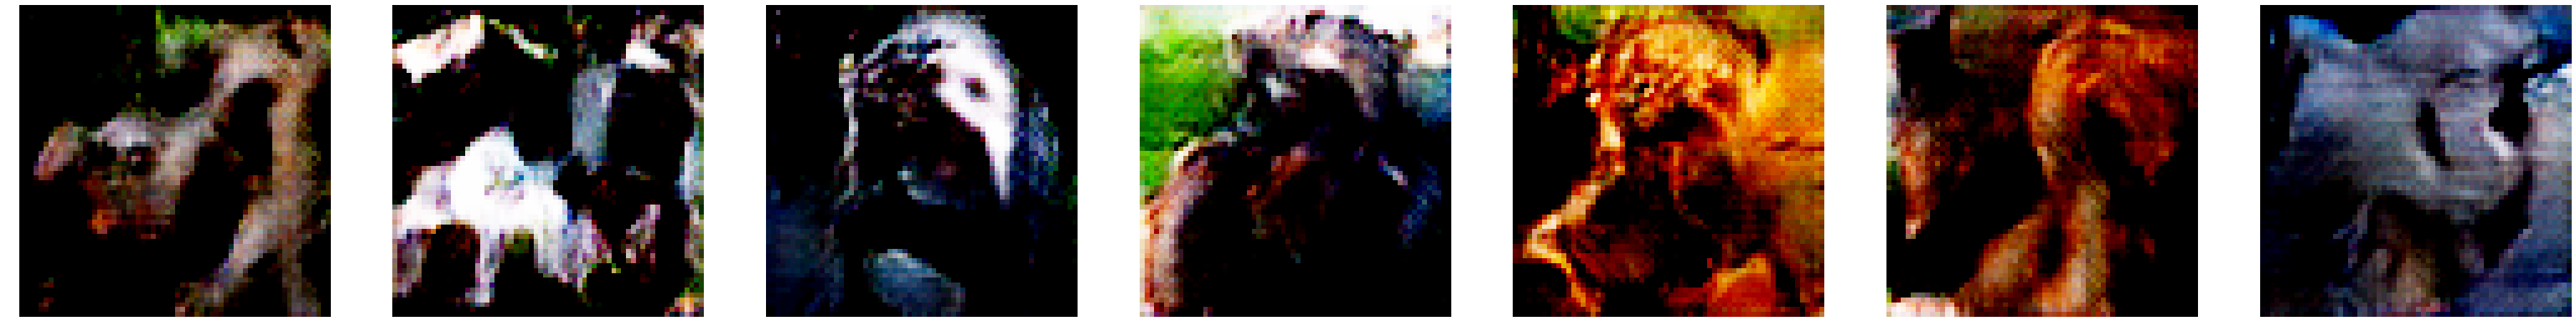

Epoch 150: 
Discriminator loss: 0.0002664666099008173
Generator loss: 2.8580246


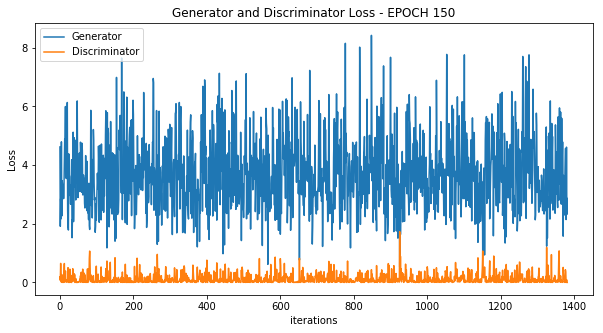

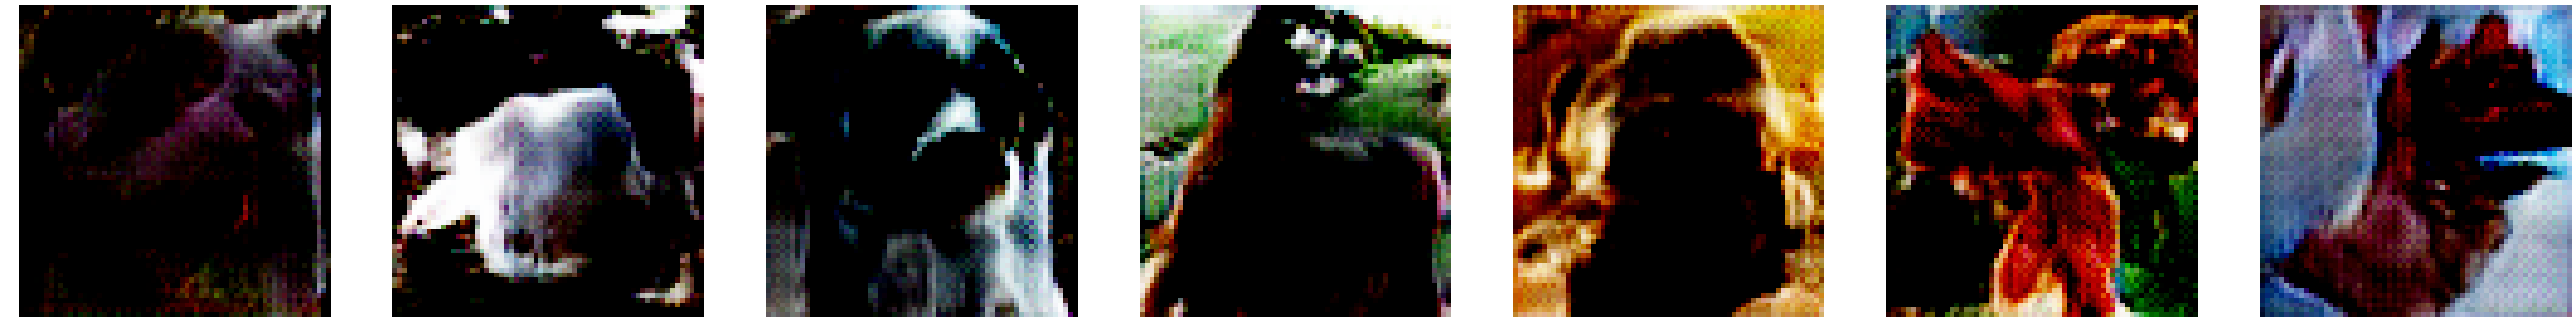

Epoch 200: 
Discriminator loss: 0.06684060394763947
Generator loss: 3.990266


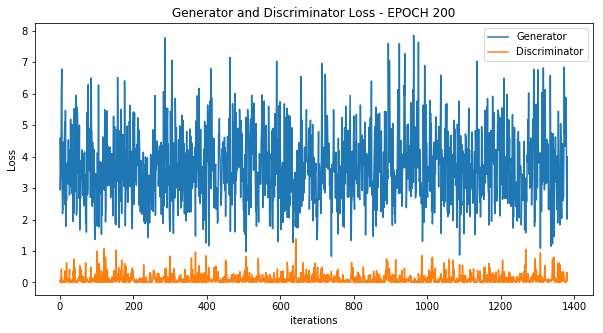

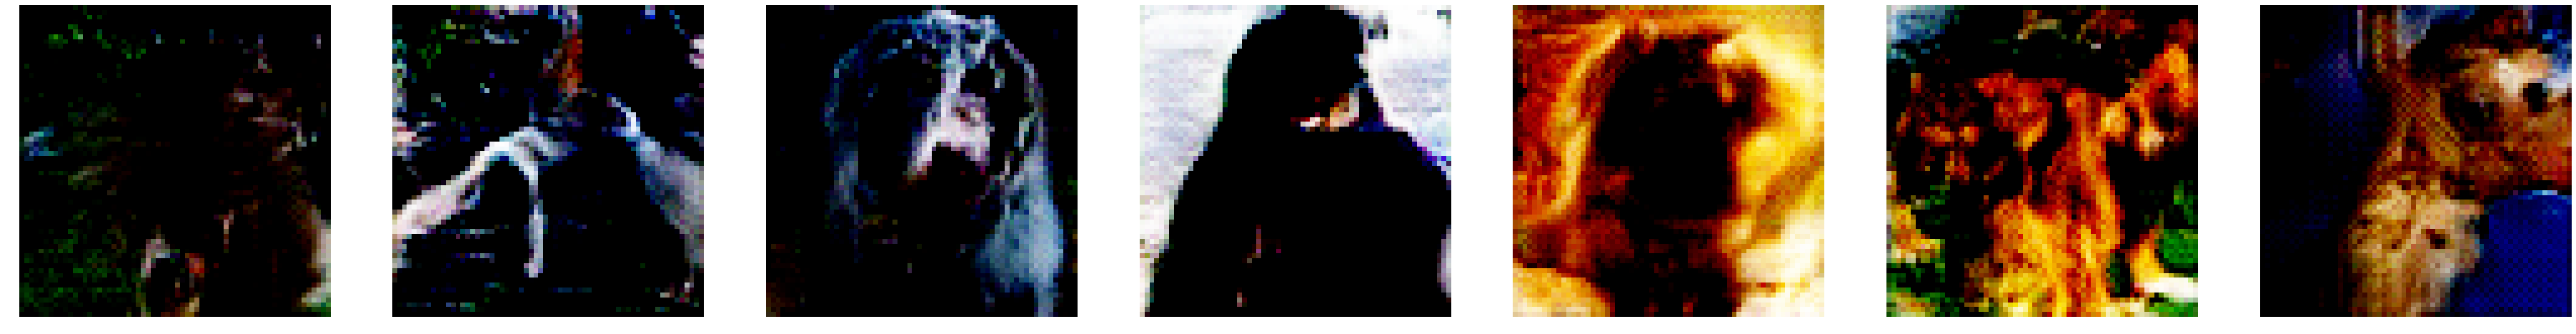

Epoch 250: 
Discriminator loss: 0.02714911475777626
Generator loss: 4.226287


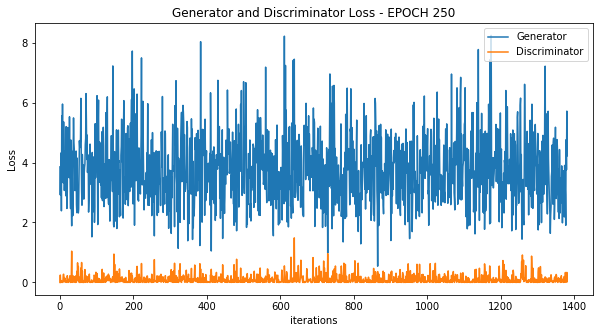

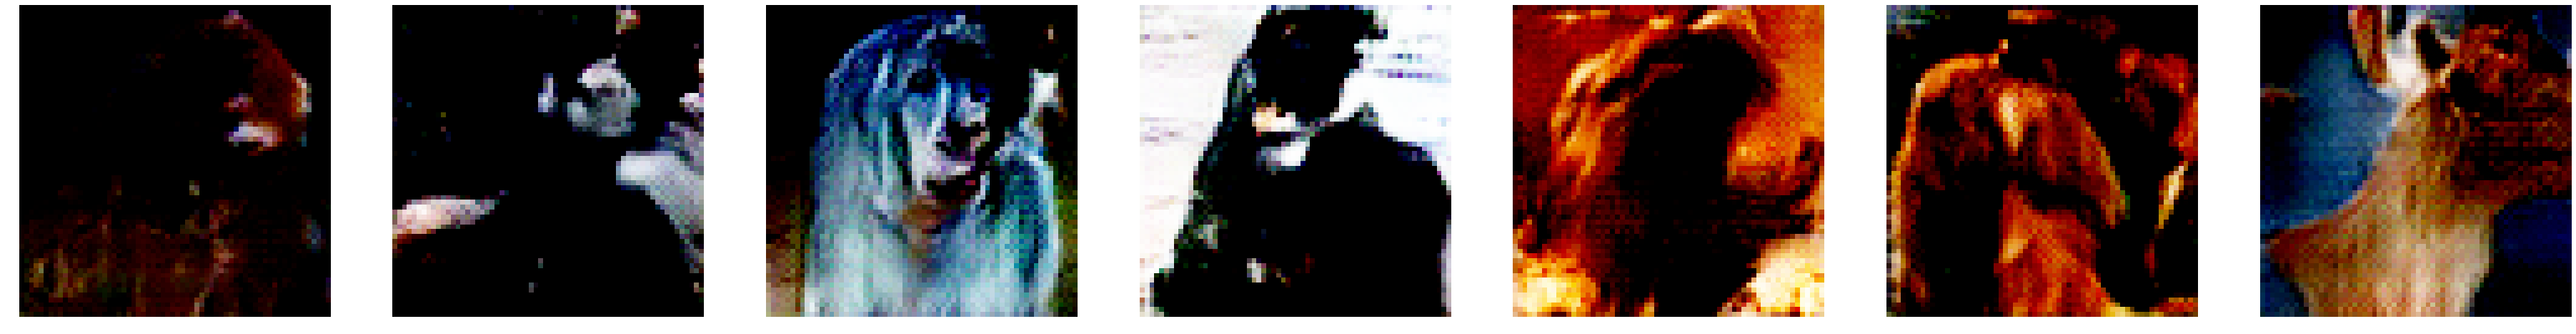

Epoch 300: 
Discriminator loss: 0.016518373042345047
Generator loss: 4.5900936


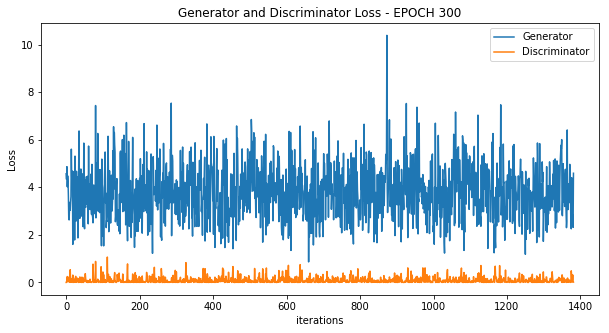

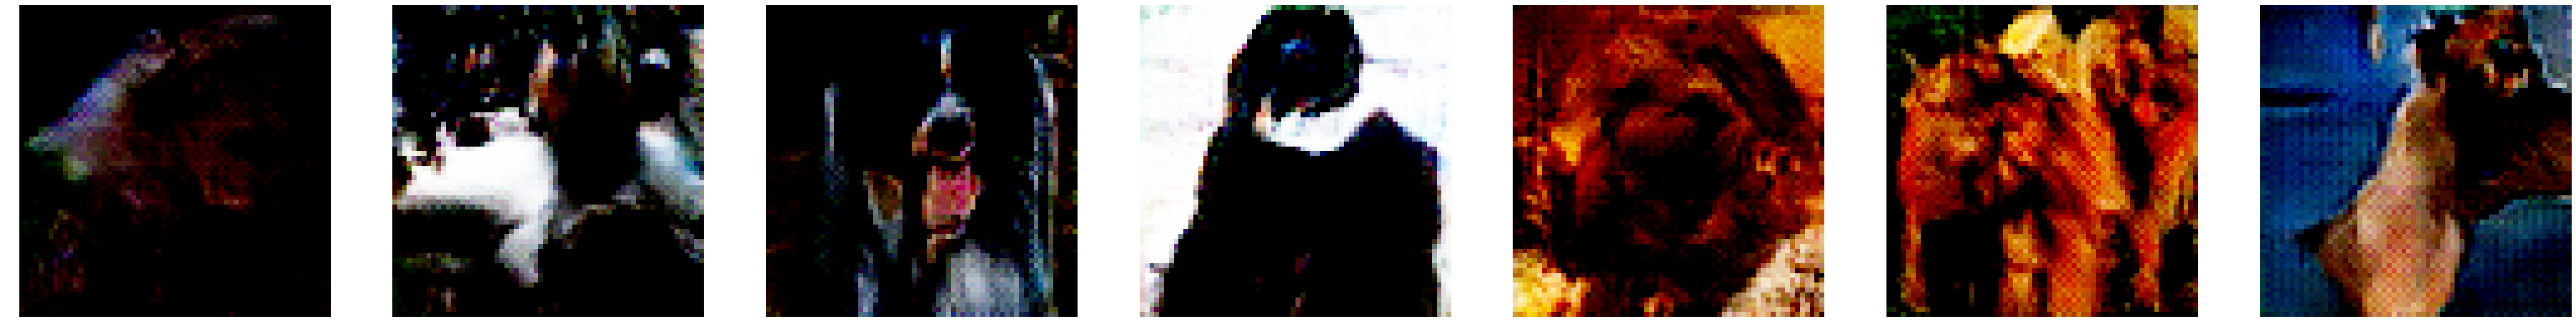

Epoch 350: 
Discriminator loss: 0.011879226192831993
Generator loss: 3.7151074


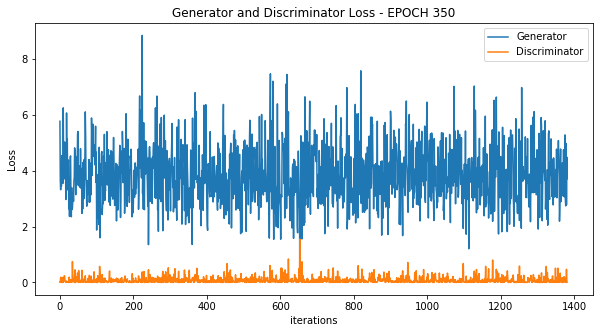

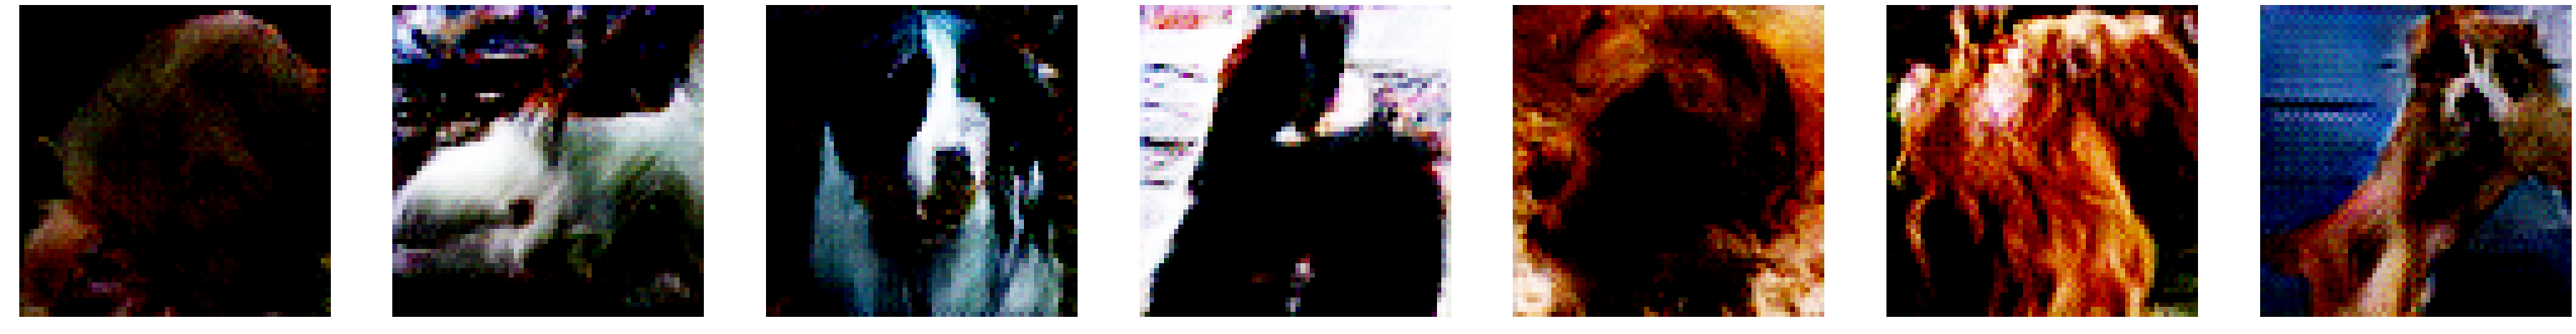

Epoch 400: 
Discriminator loss: 0.00348108634352684
Generator loss: 3.325245


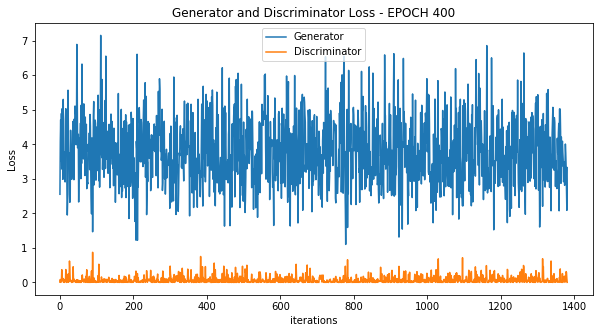

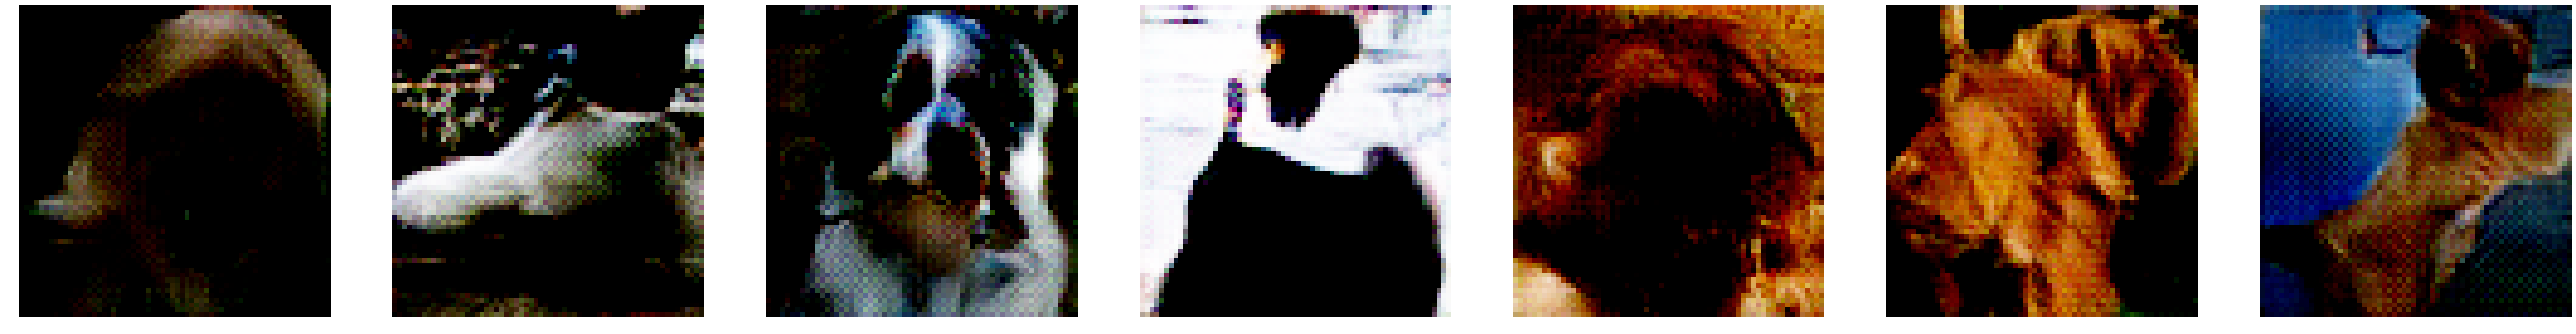

Epoch 450: 
Discriminator loss: 0.04725512117147446
Generator loss: 3.1970289


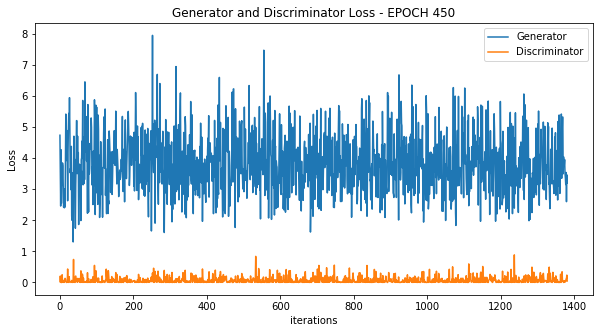

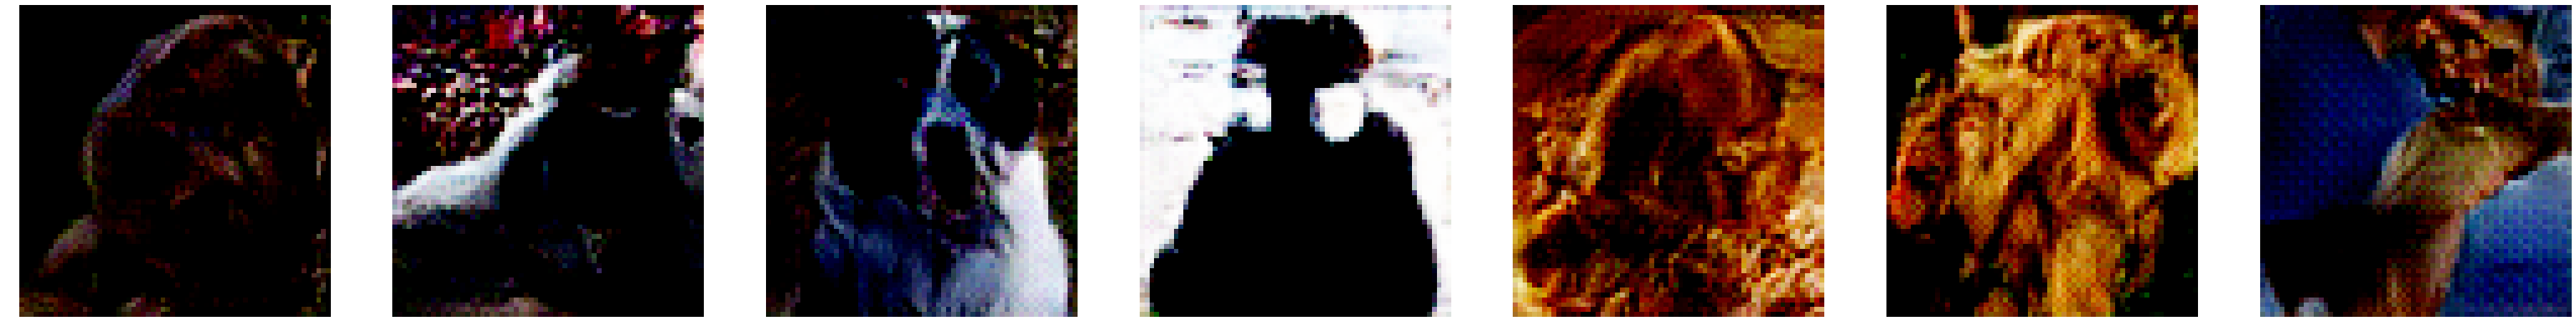

Epoch 500: 
Discriminator loss: 0.003848795313388109
Generator loss: 2.8986468


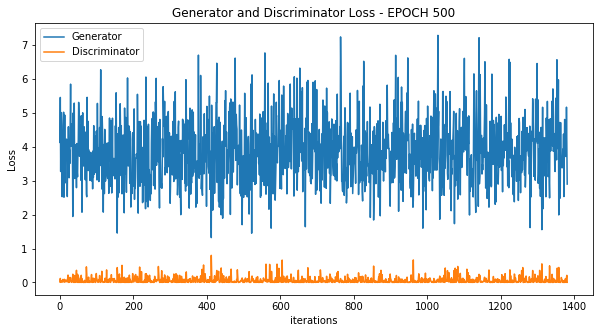

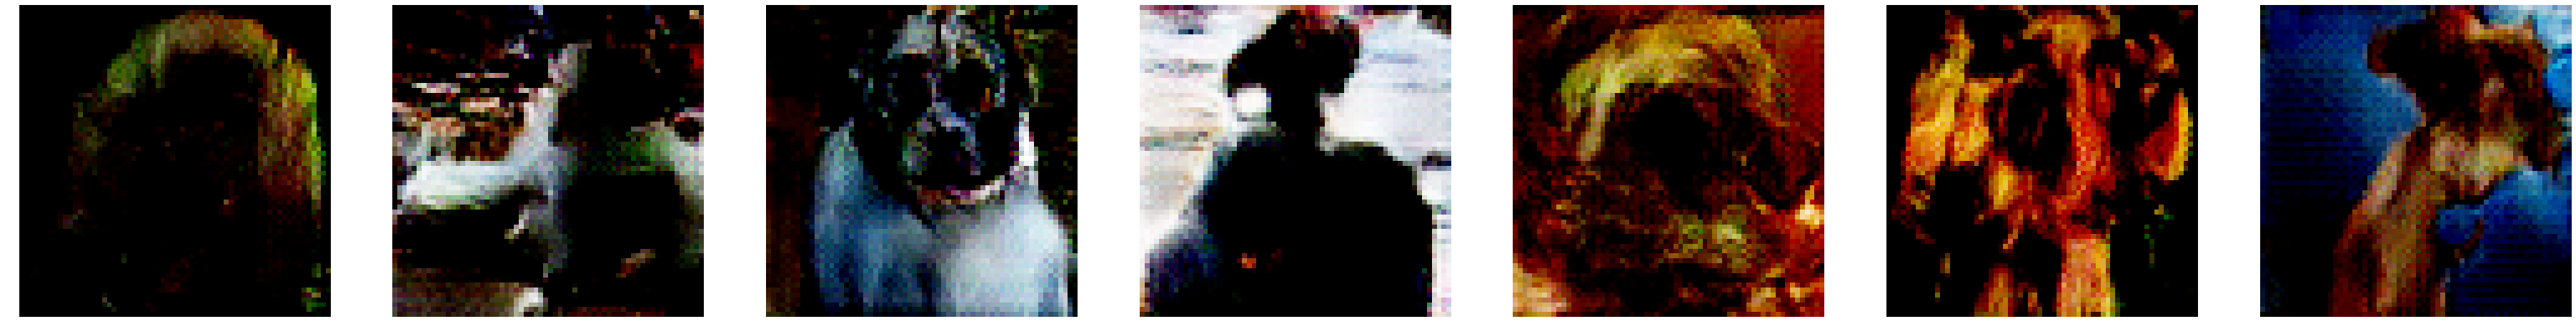

Epoch 550: 
Discriminator loss: 0.02209254913032055
Generator loss: 3.450141


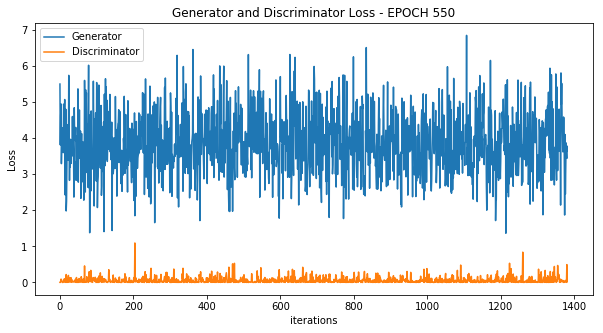

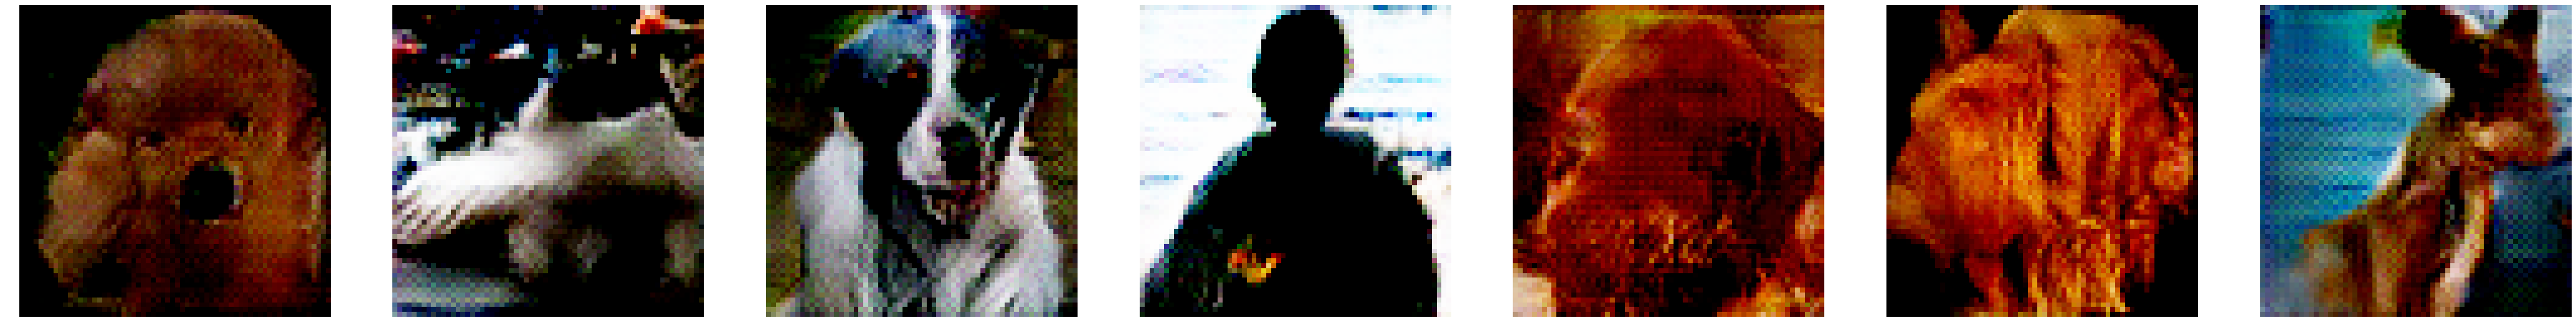

Epoch 600: 
Discriminator loss: 0.014737583696842194
Generator loss: 2.6547277


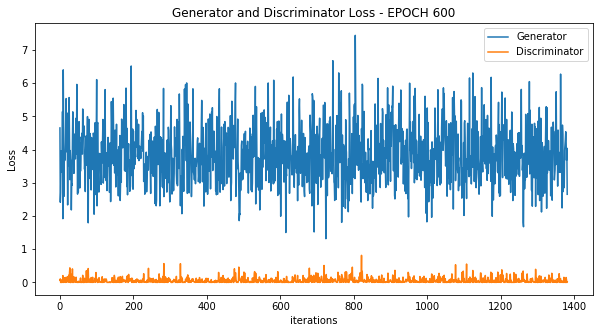

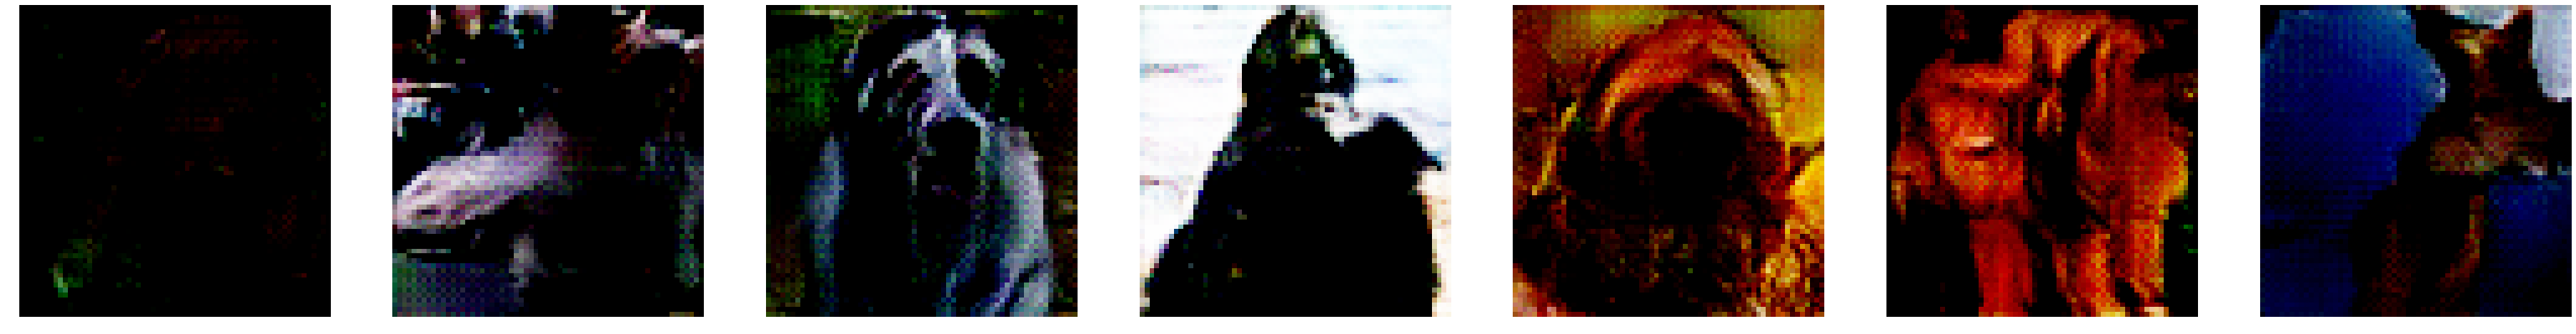

Epoch 650: 
Discriminator loss: 0.0033739323262125254
Generator loss: 3.6386437


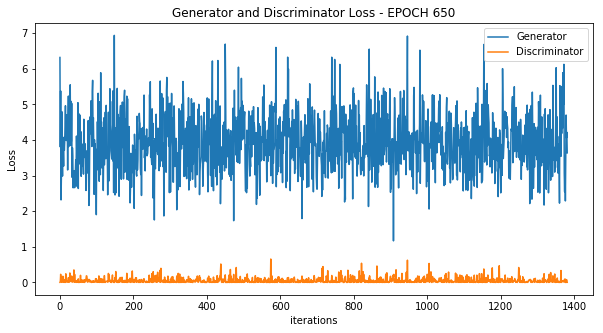

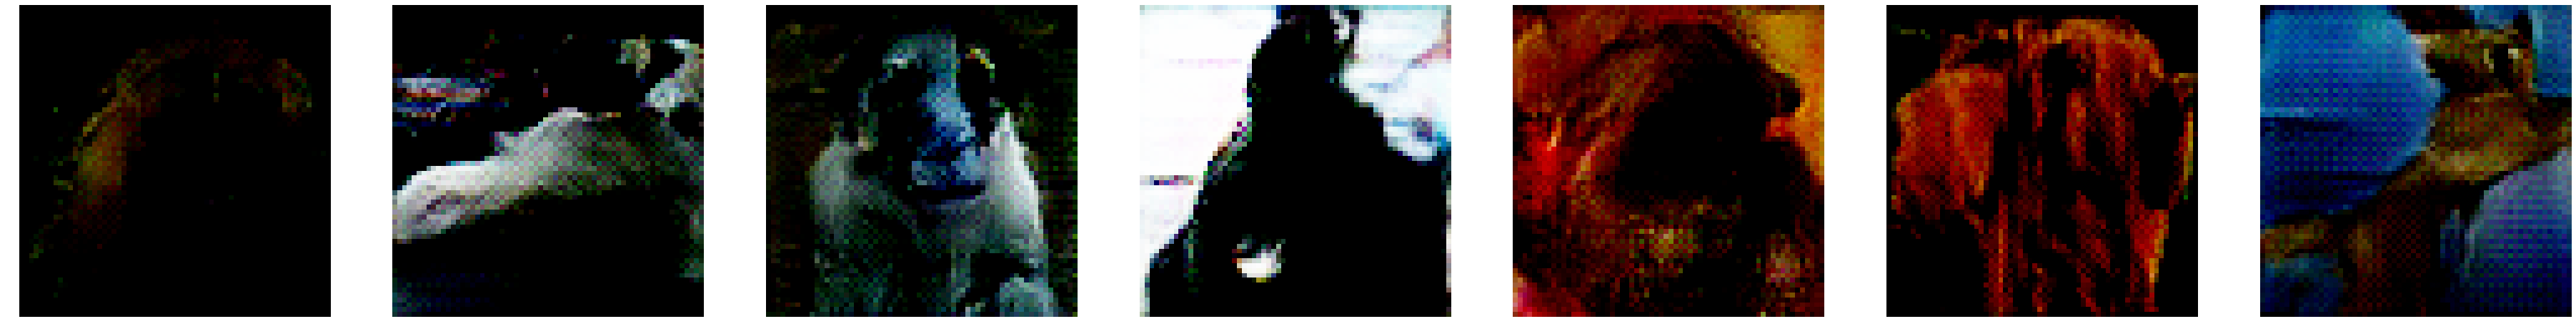

660


In [8]:
import time
epochs = 10000

test_latent = np.random.normal(size = (7,latent_dim))

# Initialize mean and standard diviation for Gaussian noise
mean = 0
var = 1
k = 1
dummy_y = np.zeros((batch_size,1))
start_time = time.time()
for epoch in range(epochs):
    batches = 0
    D_loss = []
    G_loss = []
    # Random shuffle training data
    np.random.shuffle(train_X)
    # Initialize position of start and end of batch
    start = 0
    end = start + batch_size
    for _ in range(int(len(train_X)/batch_size)):
        x_batch = train_X[start:end]
        d_loss = 0
        for _ in range(k):
            # Generate random inputs for generator
            latent_vectors = np.random.normal(size = (batch_size, latent_dim))
            # Train discriminator
            discriminator.trainable = True
            generator.trainable = False
            d_loss += dis_train.train_on_batch([latent_vectors,x_batch],dummy_y)[0]
        D_loss.append(d_loss/k)
        
        # Generate random inputs for generator
        latent_vectors = np.random.normal(size = (batch_size, latent_dim))
        # Train generator via GAN
        discriminator.trainable = False
        generator.trainable = True
        g_loss = gen_train.train_on_batch([latent_vectors,x_batch], dummy_y)
        G_loss.append(g_loss[0])
        
        # Update position for next batch
        start = end
        end += batch_size
    if epoch%50==0:
        print('Epoch ' + str(epoch) + ': ')
        print('Discriminator loss: ' + str(D_loss[-1]))
        print('Generator loss: ' + str(G_loss[-1]))
        plot_loss(G_loss, D_loss, epoch)
        test_image = generator.predict(test_latent)
        show_samples(test_image, epoch)
    end_time = time.time()
    if end_time - start_time > 31500:
        print(str(epoch))
        break
    

# Create submission

In [9]:
from keras.preprocessing.image import save_img
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')

num_images = 10000
gen_batch_size = 50
for batch in tqdm(range(0, num_images, gen_batch_size)):
    latent_vectors = np.random.normal(size=(gen_batch_size, latent_dim))
    images = generator.predict(latent_vectors)
    for i_image in range(images.shape[0]):
        save_img(os.path.join('../output_images',str(i_image + batch) + '.png'), images[i_image])
# Make archive
import shutil
shutil.make_archive('images', 'zip', '../output_images')


'/kaggle/working/images.zip'

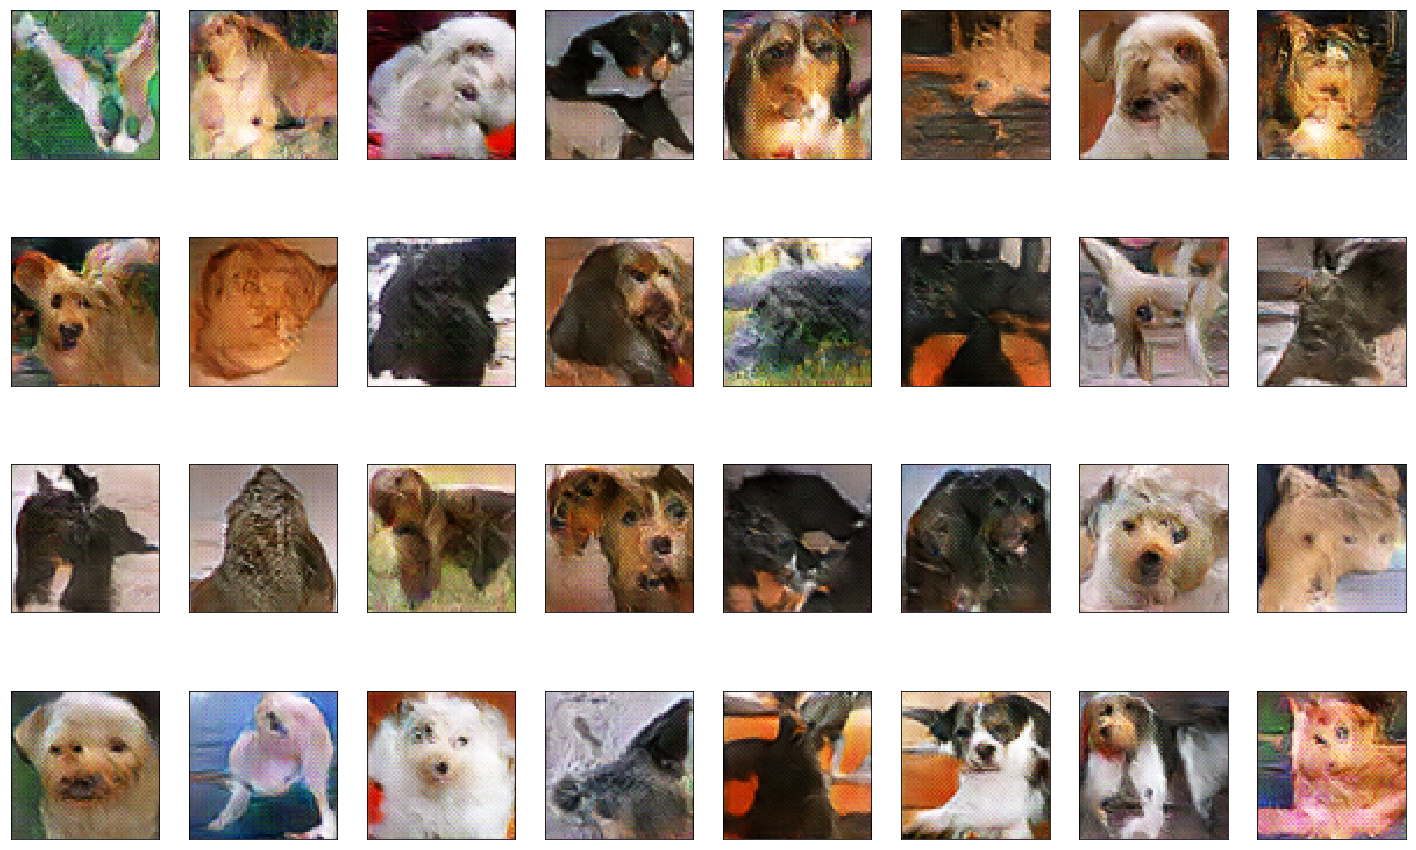

In [10]:
from keras.preprocessing.image import load_img
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(load_img(os.path.join('../output_images',str(i) + '.png')))